In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
from hmmlearn import hmm

# data obtained from: https://covid19.who.int/table
#data = pd.read_csv("WHO-COVID-19-global-data.csv")

data = pd.read_csv("https://covid19.who.int/WHO-COVID-19-global-data.csv")

print(data.columns)

data = data[['Date_reported', ' Country', ' New_cases', ' Cumulative_cases', ' New_deaths', ' Cumulative_deaths']]

country = "United States of America"
#country = "Japan"

data = data[data[' Country'] == country]

data = data.rename(columns={' Country':"Country", 
                            ' New_cases':"New_cases", 
                            ' Cumulative_cases':"Cumulative_cases", 
                            ' New_deaths':"New_deaths", 
                            ' Cumulative_deaths':"Cumulative_deaths"})

#data['Date_reported'] = pd.DatetimeIndex(data['Date_reported'])
data['Date_reported'] = pd.to_datetime(data['Date_reported'])

display(data)

Index(['Date_reported', ' Country_code', ' Country', ' WHO_region',
       ' New_cases', ' Cumulative_cases', ' New_deaths', ' Cumulative_deaths'],
      dtype='object')


,Date_reported,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
67315,2020-01-03,United States of America,0,0,0,0
67316,2020-01-04,United States of America,0,0,0,0
67317,2020-01-05,United States of America,0,0,0,0
67318,2020-01-06,United States of America,0,0,0,0
67319,2020-01-07,United States of America,0,0,0,0
...,...,...,...,...,...,...
67611,2020-10-25,United States of America,82630,8403121,943,222507
67612,2020-10-26,United States of America,82626,8485747,821,223328
67613,2020-10-27,United States of America,62364,8548111,371,223699
67614,2020-10-28,United States of America,63145,8611256,479,224178


In [83]:
#data = data[data['Date_reported'] >= pd.to_datetime("2020-04")]
#display(data)

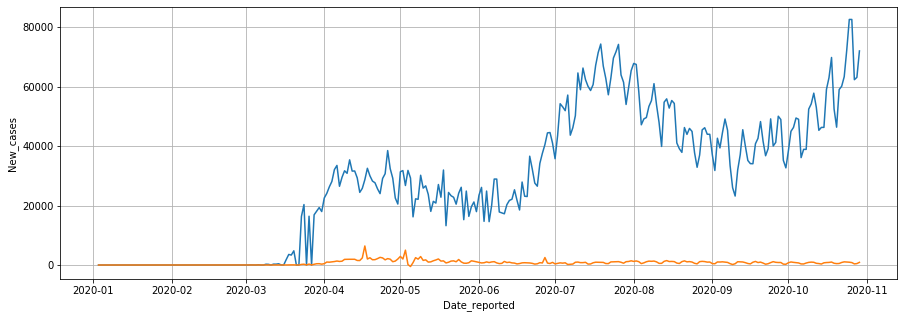

In [84]:
plt.figure(figsize=(15,5))
plt.plot(data['Date_reported'], data['New_cases'])
plt.plot(data['Date_reported'], data['New_deaths'])
plt.xlabel('Date_reported')
plt.ylabel('New_cases')
plt.grid('on')
plt.show()

/Users/yumi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in reciprocal


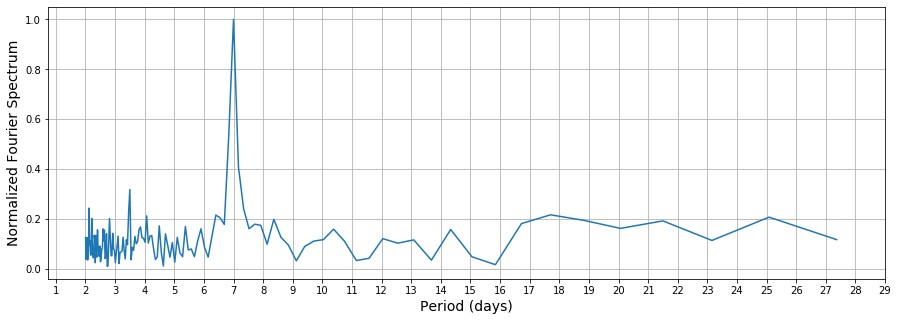

In [85]:
def FFT(y,t):
    dt=t[2]-t[1]
    Fs=1.0/dt
    L=len(y)
    Y=np.fft.fft(y,L)*dt #dt should mathematically be included in the result!
    #amp=abs(Y)/(L/2) #FFT single sided spectrum
    amp=abs(Y) #or simply take the amplitude only?
    T=L*dt #1/T=Fs/L
    freq=np.arange(0,Fs/2,1/T) #list frequencies up to Nyquist frequency
    #resize result vectors to match their lengths
    if len(freq) < len(amp):
        amp = amp[0:len(freq)]  # make both vectors the same size
    elif len(amp) < len(freq):
        freq = freq[0:len(amp)]
    return freq,amp

def freq_to_period(freq, amp):
    period = freq[::-1]**-1
    amplitude = amp[::-1]
    return period, amplitude

def set_window(period, amplitude, lim = 30):
    want = period <= lim
    period = period[want]
    amplitude = amplitude[want]
    return period, amplitude

def get_normalized_results(freq, amp, lim = 30):
    period, amplitude = freq_to_period(freq, amp)  
    period, amplitude = set_window(period, amplitude, lim)
    amplitude = amplitude/np.max(np.abs(amplitude))
    return period, amplitude

def get_fft(y):
    freq, amp = FFT(detrend(y), range(len(y)))
    period, amplitude = get_normalized_results(freq, amp, 30)
    return period, amplitude

period_cases, amplitude_cases = get_fft(data['New_cases'])

plt.figure(figsize=(15,5))
plt.plot(period_cases, amplitude_cases)
plt.ylabel('Normalized Fourier Spectrum', fontsize = 14)
plt.xlabel('Period (days)', fontsize = 14)
plt.xticks(range(1,30))
plt.grid('on')
plt.show()

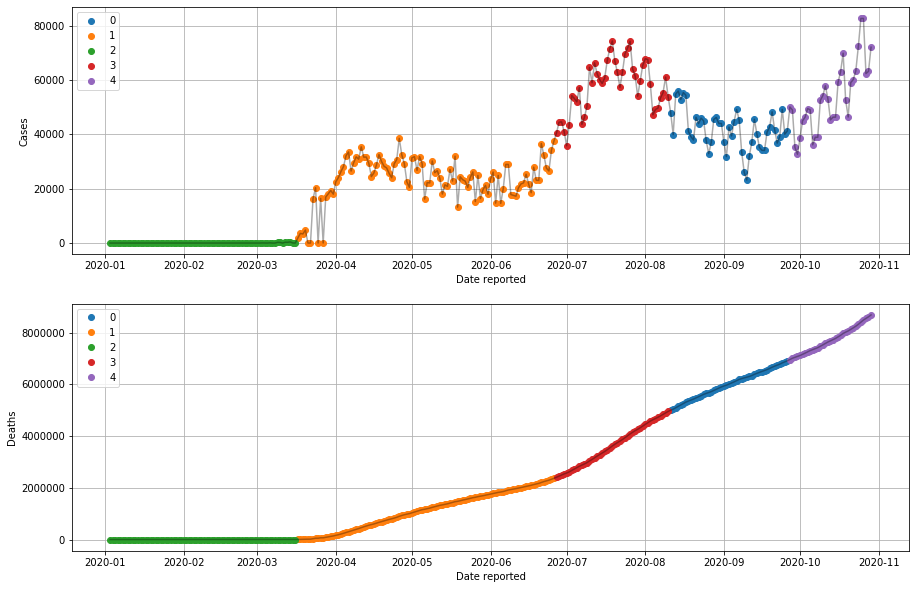

In [87]:
y = data[['New_cases','Cumulative_cases']]
model = hmm.GaussianHMM(n_components = 5)
model.fit(y)
z = model.predict(y)

plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in sorted(pd.unique(z)):
    plt.plot(data['Date_reported'].iloc[z==i], y['New_cases'].iloc[z==i], 'o')
plt.legend(sorted(pd.unique(z)))
plt.plot(data['Date_reported'], y['New_cases'], 'k', alpha = 0.33)
plt.xlabel("Date reported")
plt.ylabel("Cases")
plt.grid(True)

plt.subplot(2,1,2)
for i in sorted(pd.unique(z)):
    plt.plot(data['Date_reported'].iloc[z==i], y['Cumulative_cases'].iloc[z==i], 'o')
plt.legend(sorted(pd.unique(z)))
plt.plot(data['Date_reported'], y['Cumulative_cases'], 'k', alpha = 0.33)
plt.grid(True)
plt.xlabel("Date reported")
plt.ylabel("Deaths")
plt.show()